In [22]:
# JUPYTER NOTEBOOK CELL

import os
import re
import glob
import pickle
from typing import List, Optional, Tuple
import sys
import os
sys.path.append(os.path.abspath(".."))
from IPython.display import clear_output

from edmAnalyzer import *
import winsound
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
OUTPUT_DIR = r"C:\ACME_analysis\yield_history"
BINARY_RESULTS_NAME = "Binary Results"


def find_first_binary_results(root: str) -> Optional[str]:
    """
    Walk `root` and return the lexicographically-first folder named 'Binary Results'.
    """
    candidates: List[str] = []
    for dirpath, dirnames, _ in os.walk(root):
        # Collect exact matches only
        for d in dirnames:
            if d == BINARY_RESULTS_NAME:
                candidates.append(os.path.join(dirpath, d))
    if not candidates:
        return None
    candidates.sort()  # lexicographic; choose the first
    return candidates[0]


def trailing_digits_and_dots(name: str) -> str:
    """
    Extract trailing run of [0-9.] from the end of a string.
    If none found, fall back to the full name.
    Example: 'noname0014.1507' -> '0014.1507'
    """
    m = re.search(r'([0-9.]+)$', name)
    return m.group(1) if m else name


def load_shot_yield_from_pickle(pkl_path: str) -> np.ndarray:
    """
    Load pickle, extract binresult.shot_yield.squeeze() as 1D numpy array.
    """
    # Try normal load, then a latin1 fallback (helpful for older pickles)
    try:
        with open(pkl_path, 'rb') as f:
            obj = pickle.load(f)
    except Exception:
        with open(pkl_path, 'rb') as f:
            obj = pickle.load(f, encoding='latin1')

    if not hasattr(obj, "shot_yield"):
        raise AttributeError(f"'shot_yield' not found in {pkl_path}")

    arr = np.asarray(obj.shot_yield).squeeze()
    if arr.ndim != 1:
        raise ValueError(f"shot_yield in {pkl_path} is not 1D after squeeze (ndim={arr.ndim})")
    return arr


def build_yield_history(root: str, output_dir: str = OUTPUT_DIR, show_plot: bool = True) -> Tuple[str, str, int]:
    """
    Build the concatenated yield history from binresult_*.pkl files and save CSV + PNG.

    Returns
    -------
    csv_path, png_path, n_points : (str, str, int)
    """
    root = os.path.abspath(root)
    if not os.path.isdir(root):
        raise NotADirectoryError(f"Provided path is not a directory: {root}")

    # Suffix for filenames from the given folder name
    folder_name = os.path.basename(root.rstrip("\\/"))
    suffix = trailing_digits_and_dots(folder_name)

    # Find the first 'Binary Results' folder
    bin_results_dir = find_first_binary_results(root)
    if bin_results_dir is None:
        raise FileNotFoundError(f"No '{BINARY_RESULTS_NAME}' folder found under: {root}")

    # Collect and sort pickles
    pkl_files = sorted(glob.glob(os.path.join(bin_results_dir, "binresult_*.pkl")))
    if not pkl_files:
        raise FileNotFoundError(f"No files matching 'binresult_*.pkl' in: {bin_results_dir}")

    # Load and concatenate
    arrays = []
    for p in pkl_files:
        arr = load_shot_yield_from_pickle(p)
        arrays.append(arr)

    joined = np.concatenate(arrays, axis=0)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # File paths
    csv_path = os.path.join(output_dir, f"yieldhistory{suffix}.csv")
    png_path = os.path.join(output_dir, f"yieldhistory{suffix}.png")

    # Save CSV (single column)
    np.savetxt(csv_path, joined, delimiter=",", fmt="%.10g")

    # Plot with split lines and save PNG
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.plot(joined)
    ax.xaxis.set_major_locator(MultipleLocator(16))
    ax.xaxis.set_minor_locator(MultipleLocator(4))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.set_axisbelow(True)
    ax.grid(True, axis='x', which='major', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.grid(True, axis='x', which='minor', linestyle='-', linewidth=0.5, alpha=0.2)
    ax.set_title(f"Yield History {suffix}")
    ax.set_xlabel("Index")
    ax.set_ylabel("shot_yield")
    fig.tight_layout()
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.3)
    fig.savefig(png_path, dpi=150)
    if show_plot:
        plt.show()
    else:
        plt.close()




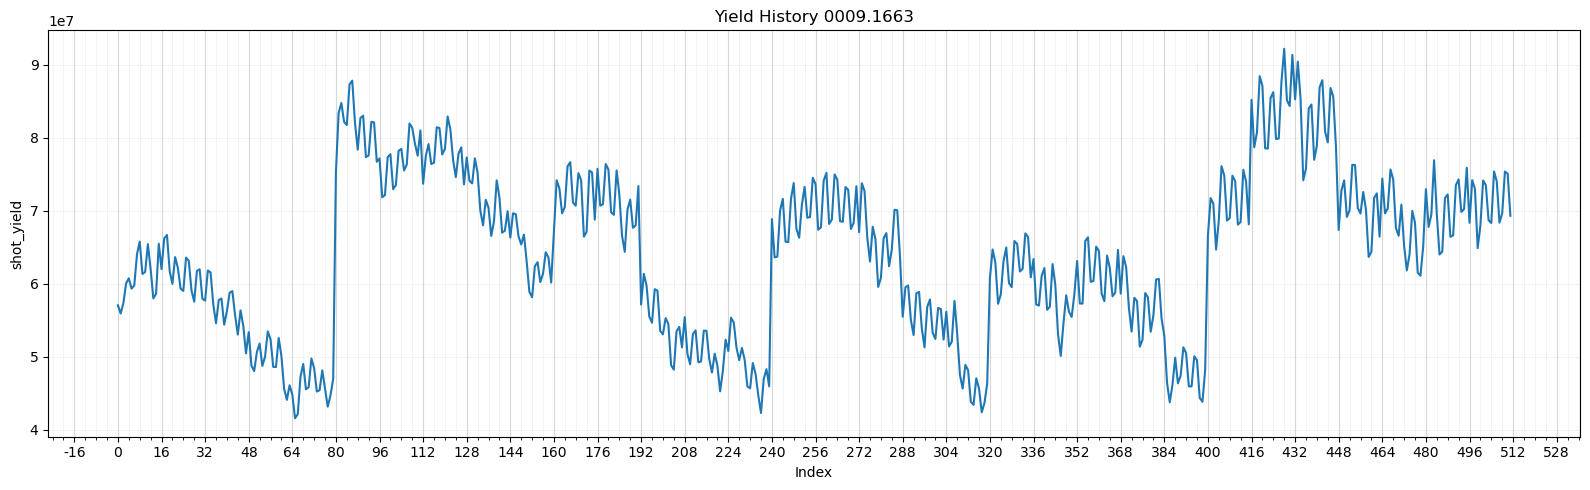

In [27]:
# --- Usage: set your folder path and run ---
# Example:
root_path = r"C:\ACME_analysis\noname0009.1663"
build_yield_history(root_path)